## [**NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION**](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#nlp-from-scratch-translation-with-a-sequence-to-sequence-network-and-attention)

### This is the third and final tutorial on doing “NLP From Scratch”, where we write our own classes and functions to preprocess the data to do our NLP modeling tasks. We hope after you complete this tutorial that you’ll proceed to learn how torchtext can handle much of this preprocessing for you in the three tutorials immediately following this one.

#### [KEY: > input, = target, < output]

\> il est en train de peindre un tableau .

= he is painting a picture .

< he is painting a picture .

This is made possible by the simple but powerful idea of the sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

To improve upon this model we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
url = "https://download.pytorch.org/tutorial/data.zip"

In [4]:
home = os.environ['HOME']
data_dir = f"{home}/torch/"
file_dir = data_dir + "data/"

In [5]:
SOS_token = 0
EOS_token = 1

In [6]:
class Lang:
    def __init__(self, name) -> None:
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for w in sentence.split(' '):
            self.addWord(w)


In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [8]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # \1 is the pattern in r"([.!?])"
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
normalizeString(' Adf56?')

'adf ?'

In [10]:
def read_Langs(lang1, lang2, reverse=False):
    file_name = file_dir + f"{lang1}-{lang2}.txt"
    lines = (open(file_name, encoding='utf-8').
                read().strip().split('\n'))
    
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs= [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)

    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

##### Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [11]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [12]:
MAX_LENGTH = 10  # filtering sentences with up to 10 words

In [13]:
def filter_Pair(p):
    return (
        len(p[0].split(' ')) < MAX_LENGTH and 
        len(p[1].split(' ')) < MAX_LENGTH and
        p[1].startswith(eng_prefixes)
    )

In [14]:
def filterPairs(pairs):
    return [pair for pair in pairs if filter_Pair(pair)]

The full process for preparing the data is:

1. Read text file and split into lines, split lines into pairs

2. Normalize text, filter by length and content

3. Make word lists from sentences in pairs

In [15]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_Langs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [16]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [17]:
random.choice(pairs)

['vous n etes pas differents .', 'you re no different .']

### [The Seq2Seq Model](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model)

##### A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps. A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

##### Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages. Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words. With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

![](https://pytorch.org/tutorials/_images/encoder-network.png)

[nn.Embedding](https://medium.com/@gautam.e/what-is-nn-embedding-really-de038baadd24)

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #print(input)
        # w_embedding just needed the indices of row to do a lookup
        embed = self.embedding(input).view(1,1,-1)
        #print(embed.size())
        output = embed
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_Hidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)

![](https://i.imgur.com/1152PYf.png)

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length=MAX_LENGTH) -> None:
        super(AttnDecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)

        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embed = self.embedding(input).view(1,1,-1)
        embed = self.dropout(embed)
        attn_weights = F.softmax(
                self.attn(torch.cat((embed[0], hidden[0]), 1)),
                dim=1
            )

        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embed[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_Hidden(self):
        return torch.zeros(1,1, self.hidden_size, device= device)

### [Training](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#training)

#### To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [20]:
def indxFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


In [21]:
def tensorFromSentence(lang, sentence):
    indexes = indxFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [22]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [23]:
pr = random.choice(pairs)

In [24]:
input_tensor, target_tensor = tensorsFromPair(pr)

### [Tarin Model](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#training-the-model)

#### To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

##### “**Teacher forcing**” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [25]:
learning_rate = 0.01
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

In [26]:
def train_Pair(
        input_tensor,
        target_tensor,
        encoder,
        encod_optim,
        decoder,
        decod_optim,
        criterion,
        max_length = MAX_LENGTH
    ):
    encoder_hidden = encoder.init_Hidden()
    encod_optim.zero_grad()
    decod_optim.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print(encoder_hidden.size(), input_length, target_length)
    encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device
    )
    
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden
        )
        #print(encoder_output.size())
        encoder_outputs[ei] = encoder_output[0, 0]

    # print(encoder_outputs.size()) == [10, 256]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
         
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [27]:
train_Pair(input_tensor, target_tensor, 
            encoder1, encoder_optimizer, 
            attn_decoder1, decoder_optimizer, 
            criterion)

7.908318519592285

Helper functions

In [28]:
import matplotlib.pyplot as plt

In [29]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [30]:
def train_Iterations(
        n_iters,
        print_every = 1000,
        plot_every = 100
    ):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    train_pairs = [
        tensorsFromPair(random.choice(pairs)) for i in range(n_iters)
    ]
 

    for iter in range(1, n_iters + 1):
        train_pair = train_pairs[iter -1]
        input_tensor = train_pair[0]
        target_tensor = train_pair[1]

        loss = train_Pair(input_tensor, target_tensor, 
                            encoder1, encoder_optimizer, 
                            attn_decoder1, decoder_optimizer, 
                             criterion)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print(
                '%s (%d, %d%%) %.4f' % (
                    timeSince(start, iter / n_iters),
                    iter,
                    iter / n_iters * 100,
                    print_loss_avg
                )
            )
            print_loss_total = 0

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [31]:
losses = train_Iterations(75000)

1m 41s (- 125m 42s) (1000, 1%) 3.3710
3m 27s (- 126m 15s) (2000, 2%) 2.6703
5m 7s (- 122m 51s) (3000, 4%) 2.4327
6m 42s (- 119m 0s) (4000, 5%) 2.2852
8m 20s (- 116m 48s) (5000, 6%) 2.2316
10m 1s (- 115m 19s) (6000, 8%) 2.1339
11m 28s (- 111m 26s) (7000, 9%) 1.9757
12m 54s (- 108m 10s) (8000, 10%) 1.9681
14m 21s (- 105m 17s) (9000, 12%) 1.8674
15m 47s (- 102m 35s) (10000, 13%) 1.7822
17m 20s (- 100m 54s) (11000, 14%) 1.7301
18m 54s (- 99m 17s) (12000, 16%) 1.6526
20m 19s (- 96m 56s) (13000, 17%) 1.6751
21m 44s (- 94m 45s) (14000, 18%) 1.6082
23m 10s (- 92m 43s) (15000, 20%) 1.5617
24m 36s (- 90m 44s) (16000, 21%) 1.4597
26m 19s (- 89m 47s) (17000, 22%) 1.4735
28m 21s (- 89m 46s) (18000, 24%) 1.4329
29m 57s (- 88m 16s) (19000, 25%) 1.3692
31m 29s (- 86m 36s) (20000, 26%) 1.3298
33m 4s (- 85m 2s) (21000, 28%) 1.3152
34m 38s (- 83m 27s) (22000, 29%) 1.2741
36m 14s (- 81m 55s) (23000, 30%) 1.2197
37m 47s (- 80m 17s) (24000, 32%) 1.2301
39m 25s (- 78m 50s) (25000, 33%) 1.1910
41m 1s (- 77m 1

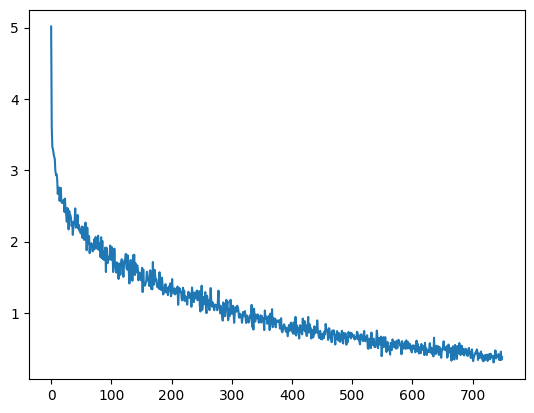

In [32]:
plt.plot(losses)

### [Evaluation](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation)

#### Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [84]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    #print(sentence)
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        #print(input_tensor)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_Hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0,0]

        decoder_input = torch.tensor([[SOS_token]], device=device)       
        decoder_hidden = encoder_hidden
        decoded_words = []

        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            decoder_attentions[di] = decoder_attn.data

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(
                    output_lang.index2word[topi.item()]
                )

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di+1]

In [91]:
def evaluate_Randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        out_words, out_attns = evaluate(encoder, decoder, pair[0])
        out_sentence = ' '.join(out_words)
        print('<', out_sentence)

In [92]:
evaluate_Randomly(encoder1, attn_decoder1)

> je suis juste a l exterieur .
= i m right outside .
< i m right outside . <EOS>
> les jeans sont en rupture de stock .
= we are sold out of jeans .
< we are sold out of jeans . <EOS>
> vous avez probablement raison .
= you re probably right .
< you re probably right . <EOS>
> nous sommes en retard .
= we re behind schedule .
< we re late . <EOS>
> nous y sommes tous ensemble .
= we re all in this together .
< we re all in this together . <EOS>
> je ne vais pas te revoir .
= i m not going to see you again .
< i m not giving you again . <EOS>
> nous sommes bourres .
= we re plastered .
< we re smashed . <EOS>
> je suis desolee de t avoir fait peur .
= i m sorry if i scared you .
< i m sorry i yelled at you . <EOS>
> vous etes influent .
= you re influential .
< you re skinny . <EOS>
> tu commets une grosse erreur .
= you re making a big mistake .
< you re making a terrible mistake . <EOS>


### [Visualizing Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#visualizing-attention)

#### A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.